In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import json
import sys

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [56]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.target import DuffingOscillator,DuffingParamTarget

In [57]:
from koopmanlib.functions import *

In [58]:
config_file = 'config_duffing.json'

In [59]:
with open(config_file, 'r') as f:
    config = json.load(f)

In [60]:
data_path = config['data_settings']['data_path']
weights_path = config['nn_settings']['weights_path']

In [61]:
n_total_data = config['data_settings']['n_total_data']

# Number of the trajectories for each choice of parameters
n_traj_per_param = config['data_settings']['n_traj_per_param']

n_param = int(n_total_data / n_traj_per_param) # Number of choices of parameters
traj_len = config['data_settings']['traj_len']
dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size = config['nn_settings']['K_layer_size']
n_psi_train = config['nn_settings']['n_psi_train']

target_dim = 2
param_dim = 3

n_psi = 1 + target_dim + n_psi_train

In [62]:
# The number of the data pairs is the multiplication of these three values
print('n_param', n_param)
print('n_traj_per_param', n_traj_per_param)

n_param 100
n_traj_per_param 100


In [63]:
# Load data
dict_data = np.load(os.path.join(data_path,'duffing_data_n_param_'+str(n_param)+'_len_'+str(traj_len)+'_n_traj_per_'+str(n_traj_per_param)+'.npy'), allow_pickle=True)
dict_data_sep = np.load(os.path.join(data_path,'duffing_data_sep_n_param_'+str(n_param)+'_len_'+str(traj_len)+'_n_traj_per_'+str(n_traj_per_param)+'.npy'), allow_pickle=True)

data_x_sep = dict_data_sep[()]['data_x_sep']
data_y_sep = dict_data_sep[()]['data_y_sep']
data_u_sep = dict_data_sep[()]['data_u_sep']

data_x = dict_data[()]['data_x']
data_y = dict_data[()]['data_y']
data_u = dict_data[()]['data_u']

In [64]:
# Collect parameters in one list
position = traj_len*n_traj_per_param * np.arange(0,n_param+1)
data_u_list = [data_u[i] for i in position[:-1]]
data_u_list = np.asarray(data_u_list)

# Test over training parameter $u$

In [65]:
traj_len_test = 50
seed_x_test = 123

## Set fixed x0 and parameter

In [66]:
# Generate testing data
duffing_test = DuffingParamTarget(n_init=1,
                               n_traj_per_param=1, 
                               traj_len=traj_len_test, 
                               seed_x=seed_x_test, 
                               seed_param=None)

## For EDMD-DL

In [67]:
from koopmanlib.solver import KoopmanDLSolver

In [68]:
def load_edmd_dl(data_x, data_y, index):
    data_train = [data_x, data_y]
    data_valid = [data_x, data_y]

    basis_function = PsiNN(layer_sizes=[100,100,100], n_psi_train=n_psi_train)

    
    solver = KoopmanDLSolver(dic=basis_function,
                             target_dim=target_dim,
                             reg=0.1)
    
    # Load weights
    
    solver.build(data_train=data_train,
                 data_valid=data_valid,
                 epochs=0,
                 batch_size=5000,
                 lr=1e-4,
                 log_interval=20,
                 lr_decay_factor=0.8)

    solver.model.load_weights(os.path.join(weights_path, 'edmd_duffing_weights_data_'+str(index)+'_n_traj_per_param_'+str(n_traj_per_param)+'_n_param_'+str(n_param)+'.h5'))
    solver.build(data_train=data_train,
                 data_valid=data_valid,
                 epochs=0,
                 batch_size=5000,
                 lr=1e-4,
                 log_interval=20,
                 lr_decay_factor=0.8)

    return solver

In [69]:
def compute_edmd_pred_data(solver, duffing_param, fixed_x0, fixed_param, traj_len):
    data_x_test, data_u_test = duffing_param.generate_fix_param_init_data(fixed_x0=fixed_x0, fixed_param=fixed_param)
    
    # Estimated trajectory from DL
    x0_test = data_x_test[0]
    x0_test = x0_test.reshape(-1,x0_test.shape[-1])

    x_est_traj_DL = solver.predict(x0_test, traj_len)
    return data_x_test, x_est_traj_DL

## For PK

In [70]:
from koopmanlib.param_solver import KoopmanParametricDLSolver
from tensorflow.keras.optimizers import Adam

dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

solver_pk = KoopmanParametricDLSolver(target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk)

model_pk, model_K_u_pred_pk = solver_pk.generate_model(layer_sizes=K_layer_size)

model_pk.load_weights(os.path.join(weights_path,'pk_duffing_weights_data_'+str(n_traj_per_param)+'_n_param_'+str(n_param)+'.h5'))

In [71]:
def compute_pk_data_list_fix_param(dic_func, model_K_u_pred, duffing_param, traj_len, fixed_x0, fixed_param):
    data_true_list = []
    data_pred_list = []
    
    data_x, data_u = duffing_param.generate_fix_param_init_data(fixed_x0=fixed_x0, fixed_param=fixed_param)
    print('u', data_u[0])
    
    B = dic_func.generate_B(data_x)
    data_x_list = [data_x]

    for _ in range(traj_len-1):
        psi_x = dic_func(data_x_list[-1])
        psi_y = model_K_u_pred([data_u, psi_x])
        y_pred = psi_y @ B
        data_x_list.append(y_pred)

    data_x_list = np.asarray(data_x_list)

    data_x_list_reshape = np.transpose(data_x_list, [1,0,2])

    data_pred = data_x_list_reshape[0]

    data_true_list.append(data_x)
    data_pred_list.append(data_pred)

    data_true_list = np.squeeze(np.asarray(data_true_list))
    data_pred_list = np.squeeze(np.asarray(data_pred_list))
    return data_true_list, data_pred_list

In [72]:
np.random.seed(seed=625)
n_sample = 5
param_index_list = np.random.randint(0,n_param, size=(n_sample,))

In [73]:
def compute_pred_error(param_index_list):

    ratio_edmd_list = []
    ratio_pk_list = []

    for index in param_index_list:
        fixed_param = data_u_list[index]

        data_x_train = data_x_sep[index]
        data_y_train = data_y_sep[index]
        data_u_train = data_u_sep[index]
        
        fixed_x0 = data_x_train[0]
        
        
        
        solver = load_edmd_dl(data_x_train, data_y_train, index)
        
        

        data_x_test_edmd_true, x_est_traj_DL_edmd = compute_edmd_pred_data(solver=solver, 
                                                                           duffing_param=duffing_test,
                                                                           fixed_x0=fixed_x0, 
                                                                           fixed_param=fixed_param, 
                                                                           traj_len=traj_len_test)
        

        data_true_list_pk, data_pred_list_pk = compute_pk_data_list_fix_param(dic_func=dic_pk,
                                                                              model_K_u_pred=model_K_u_pred_pk, 
                                                                              duffing_param=duffing_test, 
                                                                              traj_len=traj_len_test, 
                                                                              fixed_x0=fixed_x0, 
                                                                              fixed_param=fixed_param)




        ratio_pk = compute_diff_ratio_one_traj(data_true_list_pk, data_pred_list_pk)
        ratio_edmd = compute_diff_ratio_one_traj(data_true_list_pk, x_est_traj_DL_edmd)

        ratio_edmd_list.append(ratio_edmd)
        ratio_pk_list.append(ratio_pk)
        
    ratio_edmd_list = np.asarray(ratio_edmd_list)
    ratio_pk_list = np.asarray(ratio_pk_list)
    return ratio_edmd_list, ratio_pk_list

In [74]:
train_ratio_edmd_list, train_ratio_pk_list = compute_pred_error(param_index_list)

u [ 0.67883553  0.16418984 -1.19448516]
u [ 0.16983042  0.44061241 -0.44811497]
u [ 0.16983042  0.44061241 -0.44811497]
u [ 0.53589641  1.04813375 -0.2194198 ]
u [ 0.31342418  0.85624466 -0.23818513]


In [75]:
train_ratio_edmd_list_mean = np.mean(train_ratio_edmd_list, axis=0)
train_ratio_pk_list_mean = np.mean(train_ratio_pk_list, axis=0)
train_ratio_edmd_list_std = np.std(train_ratio_edmd_list, axis=0)
train_ratio_pk_list_std = np.std(train_ratio_pk_list, axis=0)

train_ratio_edmd_list_max = train_ratio_edmd_list_mean+train_ratio_edmd_list_std
train_ratio_pk_list_max = train_ratio_pk_list_mean+train_ratio_pk_list_std
train_ratio_edmd_list_min = train_ratio_edmd_list_mean-train_ratio_edmd_list_std
train_ratio_pk_list_min = train_ratio_pk_list_mean-train_ratio_pk_list_std

In [76]:
x_axis = np.arange(0,50,1)

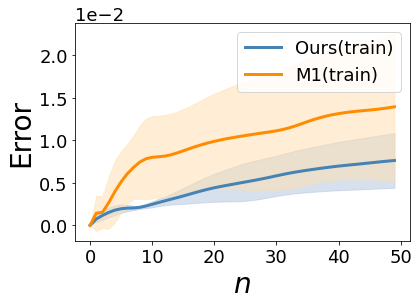

In [88]:
plt.figure(figsize=(6,4))
plt.plot(train_ratio_pk_list_mean, label='Ours(train)', color='steelblue', linewidth=3)
plt.fill_between(x_axis, train_ratio_pk_list_min, train_ratio_pk_list_max, color='lightsteelblue', alpha=0.5)

plt.plot(train_ratio_edmd_list_mean, label='M1(train)', color='darkorange', linewidth=3)
plt.fill_between(x_axis, train_ratio_edmd_list_min, train_ratio_edmd_list_max, color='navajowhite', alpha=0.5)


plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r'$n$', fontsize=28)
plt.ylabel('Error', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)


# Test over random parameter $u$

In [78]:
from sklearn.neighbors import NearestNeighbors

In [79]:
data_x_test_random, data_u_test_random = duffing_test.generate_init_data()
random_x0 = data_x_test_random[0]
query_u0 = data_u_test_random[0]

In [80]:
query_u0.shape

(3,)

In [81]:
np.random.seed(seed=625)
n_sample = 5
param_random_list = np.random.randint(0,500,size=(n_sample,3))
x_random_list = np.random.randint(0,500,size=(n_sample,1))
print('param_random_list', param_random_list)
print('x_random_list', x_random_list)

param_random_list [[307 284 412]
 [193 150 136]
 [344 209 342]
 [ 24 338 262]
 [ 19 302 205]]
x_random_list [[ 68]
 [397]
 [444]
 [459]
 [ 41]]


In [82]:
def compute_nearest_pred_data(param_random_list, x_random_list):
    # Generate testing data
    
    ratio_edmd_list = []
    ratio_pk_list = []

    for seed_param, seed_x in zip(param_random_list, x_random_list):
        duffing_test = DuffingParamTarget(n_init=1,
                                       n_traj_per_param=1, 
                                       traj_len=traj_len_test, 
                                       seed_x=seed_x, 
                                       seed_param=seed_param)
    
        data_x_test_random, data_u_test_random = duffing_test.generate_init_data()
        random_x0 = data_x_test_random[0]
        query_u0 = data_u_test_random[0]
        
        query_u0 = query_u0.reshape(1,-1)

        # Instantiate the NearestNeighbors class with k=1
        knn = NearestNeighbors(n_neighbors=1)

        # Fit the algorithm on the data
        knn.fit(data_u_list)

        # Query the nearest neighbor of a new point
        distances, u_index = knn.kneighbors(query_u0)
        
        u_index = u_index[0][0]

        fixed_param = data_u_list[u_index]
        
        data_x_train = data_x_sep[u_index]
        data_y_train = data_y_sep[u_index]
        data_u_train = data_u_sep[u_index]
        
        solver = load_edmd_dl(data_x_train, data_y_train, u_index)
        
        
        data_x_test_edmd_true, x_est_traj_DL_edmd = compute_edmd_pred_data(solver=solver, 
                                                                           duffing_param=duffing_test,
                                                                           fixed_x0=random_x0, 
                                                                           fixed_param=fixed_param, 
                                                                           traj_len=traj_len_test)
        

        data_true_list_pk, data_pred_list_pk = compute_pk_data_list_fix_param(dic_func=dic_pk,
                                                                              model_K_u_pred=model_K_u_pred_pk, 
                                                                              duffing_param=duffing_test, 
                                                                              traj_len=traj_len_test, 
                                                                              fixed_x0=random_x0, 
                                                                              fixed_param=query_u0.reshape(-1,))

        ratio_pk = compute_diff_ratio_one_traj(data_true_list_pk, data_pred_list_pk)
        ratio_edmd = compute_diff_ratio_one_traj(data_true_list_pk, x_est_traj_DL_edmd)

        ratio_edmd_list.append(ratio_edmd)
        ratio_pk_list.append(ratio_pk)
        
    ratio_edmd_list = np.asarray(ratio_edmd_list)
    ratio_pk_list = np.asarray(ratio_pk_list)
    return ratio_edmd_list, ratio_pk_list

In [83]:
test_ratio_edmd_list, test_ratio_pk_list = compute_nearest_pred_data(param_random_list, x_random_list)

u [0.32063099 1.69175527 1.77986906]
u [ 0.40198868  1.81716788 -1.38713625]
u [ 0.31388584  1.68656765 -1.73986241]
u [ 0.9600173   0.23507002 -0.4313882 ]
u [0.0975336  1.27256242 1.84104282]


In [84]:
test_ratio_edmd_list_mean = np.mean(test_ratio_edmd_list, axis=0)
test_ratio_pk_list_mean = np.mean(test_ratio_pk_list, axis=0)
test_ratio_edmd_list_std = np.std(test_ratio_edmd_list, axis=0)
test_ratio_pk_list_std = np.std(test_ratio_pk_list, axis=0)

test_ratio_edmd_list_max = test_ratio_edmd_list_mean+test_ratio_edmd_list_std
test_ratio_pk_list_max = test_ratio_pk_list_mean+test_ratio_pk_list_std
test_ratio_edmd_list_min = test_ratio_edmd_list_mean-test_ratio_edmd_list_std
test_ratio_pk_list_min = test_ratio_pk_list_mean-test_ratio_pk_list_std

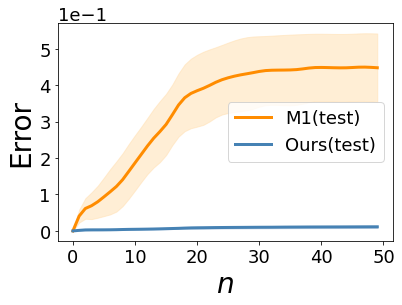

In [87]:
plt.figure(figsize=(6,4))

plt.plot(test_ratio_edmd_list_mean, label='M1(test)', color='darkorange', linewidth=3)
plt.fill_between(x_axis, test_ratio_edmd_list_min, test_ratio_edmd_list_max, color='navajowhite', alpha=0.5)

plt.plot(test_ratio_pk_list_mean, label='Ours(test)', color='steelblue', linewidth=3)
plt.fill_between(x_axis, test_ratio_pk_list_min, test_ratio_pk_list_max, color='lightsteelblue', alpha=0.5)


plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r'$n$', fontsize=28)
plt.ylabel('Error', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)


# Save data

In [ ]:
dict_mean = {'pk_train': train_ratio_pk_list_mean,
             'edmd_train': train_ratio_edmd_list_mean,
             'pk_test':test_ratio_pk_list_mean,
            'edmd_test':test_ratio_edmd_list_mean}

In [ ]:
dict_std = {'pk_train': train_ratio_pk_list_std,
             'edmd_train': train_ratio_edmd_list_std,
             'pk_test':test_ratio_pk_list_std,
            'edmd_test':test_ratio_edmd_list_std}

In [ ]:
# np.save(os.path.join(data_path, 'error_dict_n_traj_per_param_'+str(n_traj_per_param)+'_n_param_'+str(n_param)+'_mean.npy'), dict_mean)
# np.save(os.path.join(data_path, 'error_dict_n_traj_per_param_'+str(n_traj_per_param)+'_n_param_'+str(n_param)+'_std.npy'), dict_std)

# See comparison

In [89]:
n_traj_per_param_list = [1000, 500, 100]

train_pk_mean = []
train_edmd_mean = []
test_pk_mean = []
test_edmd_mean = []

for n_traj_per_param in n_traj_per_param_list:
    n_param = int(10000/n_traj_per_param)
    dict_mean = np.load(os.path.join(data_path, 'error_dict_n_traj_per_param_'+str(n_traj_per_param)+'_n_param_'+str(n_param)+'_mean.npy'), allow_pickle=True)
    dict_std = np.load(os.path.join(data_path, 'error_dict_n_traj_per_param_'+str(n_traj_per_param)+'_n_param_'+str(n_param)+'_std.npy'), allow_pickle=True)

    train_ratio_pk_list_mean = dict_mean[()]['pk_train']
    train_pk_mean.append(np.mean(train_ratio_pk_list_mean))

    train_ratio_edmd_list_mean = dict_mean[()]['edmd_train']
    train_edmd_mean.append(np.mean(train_ratio_edmd_list_mean))

    test_ratio_pk_list_mean = dict_mean[()]['pk_test']
    test_pk_mean.append(np.mean(test_ratio_pk_list_mean))

    test_ratio_edmd_list_mean = dict_mean[()]['edmd_test']
    test_edmd_mean.append(np.mean(test_ratio_edmd_list_mean))  

In [90]:
def plot_evaluate_duffing(nu, mean, dict_plot):
    plt.plot(nu, 
             mean, 
             label=dict_plot['label'],
             marker=dict_plot['marker'], 
             markersize=dict_plot['markersize'], 
             color=dict_plot['color'],
             linestyle=dict_plot['linestyle'],
             linewidth=dict_plot['linewidth'])

In [91]:
train_pk_mean = np.asarray(train_pk_mean)
train_edmd_mean = np.asarray(train_edmd_mean)
test_pk_mean = np.asarray(test_pk_mean)
test_edmd_mean = np.asarray(test_edmd_mean)

label_font = 24
ticks_font = 18
legend_font = 22

In [92]:
nu = n_traj_per_param_list
nu_xticks = ['(1000,10)', '(500,20)', '(100,100)']

dict_plot_pk_train = {'label':'Ours (train)',
                'marker':'*',
                'markersize':10,
                'color':'steelblue',
                'linestyle':'--',
                'linewidth':3
               }
dict_plot_pk_test = {'label':'Ours (test)',
                'marker':'*',
                'markersize':10,
                'color':'steelblue',
                'linestyle':'-',
                'linewidth':3
               }
dict_plot_edmd_train = {'label':'M1 (train)',
                'marker':'o',
                'markersize':10,
                'color':'darkorange',
                'linestyle':'--',
                'linewidth':3
               }
dict_plot_edmd_test = {'label':'M1 (test)',
                'marker':'o',
                'markersize':10,
                'color':'darkorange',
                'linestyle':'-',
                'linewidth':3
               }

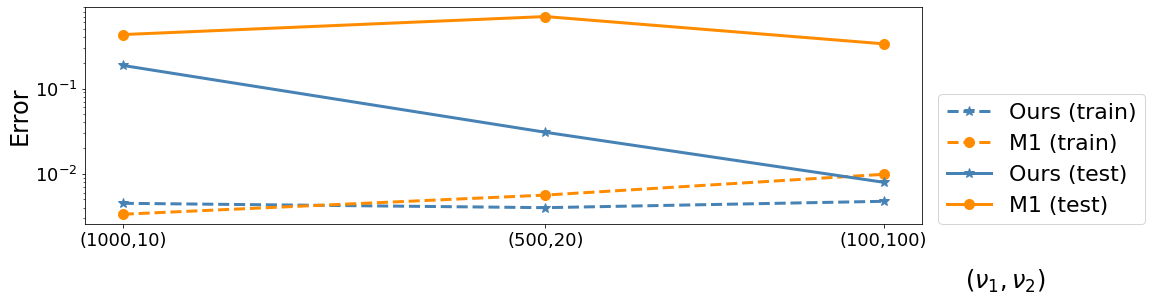

In [93]:
plt.figure(figsize=(15,4))
plot_evaluate_duffing(nu, train_pk_mean, dict_plot_pk_train)
plot_evaluate_duffing(nu, train_edmd_mean, dict_plot_edmd_train)
plot_evaluate_duffing(nu, test_pk_mean, dict_plot_pk_test)
plot_evaluate_duffing(nu, test_edmd_mean, dict_plot_edmd_test)
plt.xlabel(r'$(\nu_{1}, \nu_{2})$', labelpad=20, fontsize=label_font)
plt.gca().xaxis.set_label_coords(1.1, -0.2)
plt.ylabel('Error', fontsize=label_font)
plt.xticks(nu, nu_xticks, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.gca().invert_xaxis()
plt.yscale('log')
plt.legend(fontsize=legend_font, loc=(1.02,0.0))